# Read this section importantly!

In [9]:
!nvidia-smi

Tue May  2 19:07:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.4 MB/s eta 0:00:00


In [3]:
pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.0 MB/s eta 0:00:00


In [4]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [10]:
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
  df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  #SMA  #10days
  df11['SMA10'] = df11['Close'].rolling(10).mean()

  df11.drop(columns=['Close','change','index'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat
APPL_price = pd.read_csv("AAPL.csv")
APPL=technical_indicators(APPL_price).drop(columns=['Date','Adj Close'])
print(APPL.columns)
# APPL=APPL.reset_index()
APPL

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'delta', 'SMA10'], dtype='object')


,Open,High,Low,Close,Volume,change,delta,SMA10
0,7.622500,7.660714,7.585000,7.643214,493729600,0.013215,0.0,7.520571
1,7.664286,7.699643,7.616071,7.656429,601904800,0.013215,1.0,7.520571
2,7.656429,7.686786,7.526786,7.534643,552160000,-0.121786,0.0,7.520571
3,7.562500,7.571429,7.466071,7.520714,477131200,-0.013929,0.0,7.520571
4,7.510714,7.571429,7.466429,7.570714,447610800,0.050000,1.0,7.520571
...,...,...,...,...,...,...,...,...
3348,165.000000,165.600006,163.889999,165.330002,41949600,0.309998,1.0,164.800002
3349,165.190002,166.309998,163.729996,163.770004,48714100,-1.559998,0.0,165.097002
3350,163.059998,165.279999,162.800003,163.759995,45498800,-0.010009,0.0,165.463001
3351,165.190002,168.559998,165.190002,168.410004,64902300,4.650009,1.0,165.748001


### **Standardize**

In [18]:
#Normalize time series
Scaler = StandardScaler()
dataset_standard = Scaler.fit_transform(APPL)
dataset=dataset_standard
dataset_standard

array([[-0.93627478, -0.93569616, -0.93641179, ..., -0.02453614,
        -1.0548893 , -0.93705031],
       [-0.93542584, -0.93491534, -0.93577291, ..., -0.02453614,
         0.94796677, -0.93705031],
       [-0.93558547, -0.93517322, -0.93760877, ..., -0.11886667,
        -1.0548893 , -0.93705031],
       ...,
       [ 2.22166273,  2.22575885,  2.25507752, ..., -0.04076366,
        -1.0548893 ,  2.27957072],
       [ 2.26493684,  2.29154756,  2.30422004, ...,  3.21537522,
         0.94796677,  2.28537498],
       [ 2.33198118,  2.31742194,  2.35953116, ...,  0.85362156,
         0.94796677,  2.29447845]])

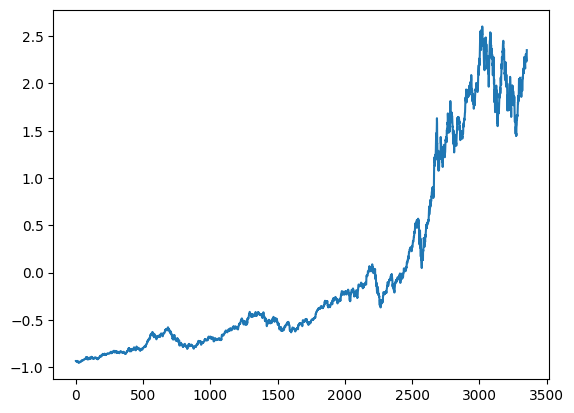

In [19]:
plt.plot(dataset_standard[:,3]) #plot closing price

### **Train Test Split**

In [20]:
# dataset=np.array(APPL)
dataset=dataset.tolist()*1  #TODO: try to Tune, to repeat stock price make longer dataset
len(dataset)
a=int(0.8*len(dataset))
X_train=dataset[0:a]
X_test=dataset[a:]
print(len(X_train))
len(X_test)


2682


671

In [ ]:
# data=dataset[]

In [21]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

### **Dataset**

In [22]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start, end = self.indices[index]

        sequence = self.data[start:end]

        src = sequence[:self.enc_seq_len]      #0~59 inclusive
        tgt = sequence[self.enc_seq_len-self.pred_seq_len+1 : self.enc_seq_len+1]     #56~60 inclusive
        true = sequence[self.enc_seq_len+1:]     #61~65 inclusive

        return src, tgt, true
    

In [23]:
def get_windows(data, window_size, step_size):
    start = 0
    end = window_size
    
    indices = []
    while end < len(data):      #proceed window by step size, count how many sequences 
        indices.append( (start, end) )
        start += step_size
        end += step_size
    return indices

In [ ]:
# plt.plot(np.array(X_train)[:,4])

torch.Size([128, 30, 8]) torch.Size([128, 7, 8])
x:  tensor([-0.7411, -0.7393, -0.7385, -0.7374, -0.7376, -0.7382, -0.7378, -0.7376,
        -0.7368, -0.7354, -0.7347, -0.7338, -0.7323, -0.7304, -0.7280, -0.7251,
        -0.7223, -0.7193, -0.7168, -0.7144, -0.7131, -0.7113, -0.7100, -0.7092,
        -0.7088, -0.7084, -0.7087, -0.7101, -0.7105, -0.7113])
tgt:  tensor([-0.7088, -0.7084, -0.7087, -0.7101, -0.7105, -0.7113, -0.7111])
y_train:  tensor([-0.7114, -0.7110, -0.7106, -0.7112, -0.7116, -0.7121, -0.7114])


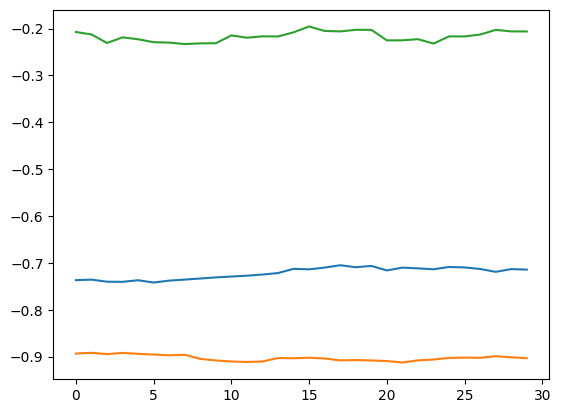

In [24]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=30
pred_len=7
window_size=context_len+pred_len+1
training_indices = get_windows(X_train, window_size, step_size=3) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=1) #TODO: Tune step size... 
test_indices = get_windows(dataset, window_size, step_size=1) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len) 
test_data=TransformerDataset(torch.FloatTensor(dataset), test_indices, context_len, pred_len) 

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 1,
    pin_memory  = False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape)
    print("x: ", src[0,:,-1])   #60 days context  
    print("tgt: ", tgt[0,:,-1]) #should be next five days 
    print("y_train: ", y_train[0,:,-1])  #True label should shift by one to right
    plt.plot(src[0,:,3])
    plt.plot(src[1,:,3])
    plt.plot(src[2,:,3]) #
    break

### **Positional Encoding and Transformer**

In [25]:
class PositionalEncoder(nn.Module):
    def __init__(self,  max_seq_len = 5000, d_model = 512, dropout= 0.1,):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        time = torch.arange(0, max_seq_len).unsqueeze(1)
        self.positional_encoding = torch.zeros(1,max_seq_len, d_model).to(DEVICE)
        xx= (torch.arange(0,max_seq_len).reshape(-1, 1).to(DEVICE)) / torch.pow(10000, torch.arange(0, d_model, 2)/d_model).to(DEVICE)
        self.positional_encoding[:, :, 0::2] = torch.sin(xx)
        self.positional_encoding[:, :, 1::2] = torch.cos(xx)

        self.register_buffer('pe', self.positional_encoding)

    def forward(self, x) :
        x = x + self.positional_encoding[:,:x.shape[1]]
        x=self.dropout(x)
        return x


In [39]:
class Transformer(nn.Module):
    def __init__(self, input_dim=8, output_dim=1, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model, 1)
        self.positional_encoding_layer = PositionalEncoder(encode_seq_len, d_model, dropout  )

    def forward(self, x, query, src_mask=None, tgt_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        #encode query
        query=self.embedding(query) 

        encoder_out = self.encoder(x)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        # attn_weights = self.decoder.layers[-1].multihead_attn.attn_output_weights

        decoder_out = self.linear_out(decoder_out)
        
        return decoder_out


In [40]:
gc.collect()
torch.cuda.empty_cache()

### **Define Model**

In [85]:
#TODO: tune model parameters
model=Transformer(input_dim=8, output_dim=1, d_model=512, nhead=4, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=256, 
                  dropout=0.3, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for x, y,z in train_loader: 
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    out=model(x,y)
    print("x shape:", x.shape, "y shape:", y.shape)
    print("out shape:", out.shape)
    summary(model, x, y)
    break
print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([128, 30, 8]) y shape: torch.Size([128, 7, 8])
out shape: torch.Size([128, 7, 1])
                                            Kernel Shape    Output Shape  \
Layer                                                                      
0_embedding                                     [8, 512]  [128, 30, 512]   
1_positional_encoding_layer.Dropout_dropout            -  [128, 30, 512]   
2_embedding                                     [8, 512]   [128, 7, 512]   
3_encoder.layers.0.Dropout_dropout1                    -  [128, 30, 512]   
4_encoder.layers.0.LayerNorm_norm1                 [512]  [128, 30, 512]   
5_encoder.layers.0.Linear_linear1             [512, 256]  [128, 30, 256]   
6_encoder.layers.0.Dropout_dropout                     -  [128, 30, 256]   
7_encoder.layers.0.Linear_linear2             [256, 512]  [128, 30, 512]   
8_encoder.layers.0.Dropout_dropout2                    -  [128, 30, 512]   
9_encoder.layers.0.LayerNorm_norm2                 [512]  [128

# Model Setup 

# Loss Function, Optimizers, Scheduler

In [42]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.SmoothL1Loss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Train and Validation functions 


In [43]:
class Trainer():
  def __init__(self, model, loader, optimizer, criterion, scheduler, val_loader):
    self.model      = model
    self.loader     = loader
    self.optimizer  = optimizer
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher=True
    self.val_loader=val_loader
    
  def train(self, teacher_forcing_rate):
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.optimizer.zero_grad()

          src, trg, y_train = batch

          src = src.to(device)
          trg = trg.to(device)
          y_train = y_train.to(device)

          batch_size = src.shape[0]

          tgt_mask = torch.triu(torch.ones( batch_size*self.model.nhead, pred_len, pred_len) * float('-inf'), diagonal=1).to(device)
          y_pred = self.model(src, trg, src_mask=None, tgt_mask=tgt_mask).reshape(-1,1)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=3
          loss = criterion(y_pred, y_train[:,:,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns
          
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1e+6)
          optimizer.step()
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del src, trg, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):
          self.optimizer.zero_grad()

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)

          batch_size = src.shape[0]

          tgt_mask = torch.triu(torch.ones( batch_size*self.model.nhead, pred_len, pred_len) * float('-inf'), diagonal=1).to(device)

          y_pred = self.model(src, trg, src_mask=None, tgt_mask=tgt_mask).reshape(-1,1)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=3
          # print(y_pred[:,1].shape,y_test[:,1,pred_what].shape)
          val_loss = criterion(y_pred[:,0], y_test[:,0,pred_what].reshape(-1,1))    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self, test_loader):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            self.optimizer.zero_grad()

            src, trg, y_test = batch

            src = src.to(device)
            trg = trg.to(device)

            batch_size = src.shape[0]

            tgt_mask = torch.triu(torch.ones( batch_size*self.model.nhead, pred_len, pred_len) * float('-inf'), diagonal=1).to(device)

            y_pred = self.model(src, trg, src_mask=None, tgt_mask=tgt_mask)
            prediction.append(y_pred[0])

            #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
            del src, trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [44]:
gc.collect()
torch.cuda.empty_cache()

In [45]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)
trainer=Trainer(model, train_loader, optimizer, criterion,  scheduler, val_loader=val_loader)


Epoch: 1/100


	Train Loss 0.6438	 Learning Rate 0.0001000	 Validation Loss 0.4549

Epoch: 2/100


	Train Loss 0.1325	 Learning Rate 0.0000995	 Validation Loss 0.1885

Epoch: 3/100


	Train Loss 0.0757	 Learning Rate 0.0000990	 Validation Loss 0.1293

Epoch: 4/100


	Train Loss 0.0500	 Learning Rate 0.0000985	 Validation Loss 0.1343

Epoch: 5/100


	Train Loss 0.0355	 Learning Rate 0.0000980	 Validation Loss 0.1532

Epoch: 6/100


	Train Loss 0.0296	 Learning Rate 0.0000975	 Validation Loss 0.1436

Epoch: 7/100


	Train Loss 0.0255	 Learning Rate 0.0000970	 Validation Loss 0.1904

Epoch: 8/100


	Train Loss 0.0229	 Learning Rate 0.0000966	 Validation Loss 0.1660

Epoch: 9/100


	Train Loss 0.0228	 Learning Rate 0.0000961	 Validation Loss 0.2168

Epoch: 10/100


	Train Loss 0.0208	 Learning Rate 0.0000956	 Validation Loss 0.2077

Epoch: 11/100


	Train Loss 0.0214	 Learning Rate 0.0000951	 Validation Loss 0.2006

Epoch: 12/100


	Train Loss 0.0194	 Learning Rate 0.0000946	 Validation Loss 0.1836

Epoch: 13/100


	Train Loss 0.0185	 Learning Rate 0.0000942	 Validation Loss 0.1799

Epoch: 14/100


	Train Loss 0.0180	 Learning Rate 0.0000937	 Validation Loss 0.2078

Epoch: 15/100


	Train Loss 0.0180	 Learning Rate 0.0000932	 Validation Loss 0.1878

Epoch: 16/100


	Train Loss 0.0168	 Learning Rate 0.0000928	 Validation Loss 0.1665

Epoch: 17/100


	Train Loss 0.0157	 Learning Rate 0.0000923	 Validation Loss 0.1680

Epoch: 18/100


	Train Loss 0.0157	 Learning Rate 0.0000918	 Validation Loss 0.1473

Epoch: 19/100


	Train Loss 0.0152	 Learning Rate 0.0000914	 Validation Loss 0.1462

Epoch: 20/100


	Train Loss 0.0150	 Learning Rate 0.0000909	 Validation Loss 0.1313

Epoch: 21/100


	Train Loss 0.0140	 Learning Rate 0.0000905	 Validation Loss 0.1595

Epoch: 22/100


	Train Loss 0.0137	 Learning Rate 0.0000900	 Validation Loss 0.1433

Epoch: 23/100


	Train Loss 0.0130	 Learning Rate 0.0000896	 Validation Loss 0.1397

Epoch: 24/100


	Train Loss 0.0122	 Learning Rate 0.0000891	 Validation Loss 0.0970

Epoch: 25/100


	Train Loss 0.0125	 Learning Rate 0.0000887	 Validation Loss 0.1244

Epoch: 26/100


	Train Loss 0.0116	 Learning Rate 0.0000882	 Validation Loss 0.1026

Epoch: 27/100


	Train Loss 0.0119	 Learning Rate 0.0000878	 Validation Loss 0.0973

Epoch: 28/100


	Train Loss 0.0112	 Learning Rate 0.0000873	 Validation Loss 0.0952

Epoch: 29/100


	Train Loss 0.0105	 Learning Rate 0.0000869	 Validation Loss 0.1053

Epoch: 30/100


	Train Loss 0.0103	 Learning Rate 0.0000865	 Validation Loss 0.0843

Epoch: 31/100


	Train Loss 0.0100	 Learning Rate 0.0000860	 Validation Loss 0.0735

Epoch: 32/100


	Train Loss 0.0097	 Learning Rate 0.0000856	 Validation Loss 0.0760

Epoch: 33/100


	Train Loss 0.0096	 Learning Rate 0.0000852	 Validation Loss 0.0769

Epoch: 34/100


	Train Loss 0.0090	 Learning Rate 0.0000848	 Validation Loss 0.0804

Epoch: 35/100


	Train Loss 0.0088	 Learning Rate 0.0000843	 Validation Loss 0.0818

Epoch: 36/100


	Train Loss 0.0085	 Learning Rate 0.0000839	 Validation Loss 0.0755

Epoch: 37/100


	Train Loss 0.0082	 Learning Rate 0.0000835	 Validation Loss 0.0697

Epoch: 38/100


	Train Loss 0.0080	 Learning Rate 0.0000831	 Validation Loss 0.0675

Epoch: 39/100


	Train Loss 0.0077	 Learning Rate 0.0000827	 Validation Loss 0.0680

Epoch: 40/100


	Train Loss 0.0075	 Learning Rate 0.0000822	 Validation Loss 0.0638

Epoch: 41/100


	Train Loss 0.0073	 Learning Rate 0.0000818	 Validation Loss 0.0639

Epoch: 42/100


	Train Loss 0.0071	 Learning Rate 0.0000814	 Validation Loss 0.0613

Epoch: 43/100


	Train Loss 0.0070	 Learning Rate 0.0000810	 Validation Loss 0.0689

Epoch: 44/100


	Train Loss 0.0066	 Learning Rate 0.0000806	 Validation Loss 0.0732

Epoch: 45/100


	Train Loss 0.0067	 Learning Rate 0.0000802	 Validation Loss 0.0617

Epoch: 46/100


	Train Loss 0.0063	 Learning Rate 0.0000798	 Validation Loss 0.0589

Epoch: 47/100


	Train Loss 0.0061	 Learning Rate 0.0000794	 Validation Loss 0.0606

Epoch: 48/100


	Train Loss 0.0061	 Learning Rate 0.0000790	 Validation Loss 0.0582

Epoch: 49/100


	Train Loss 0.0060	 Learning Rate 0.0000786	 Validation Loss 0.0622

Epoch: 50/100


	Train Loss 0.0060	 Learning Rate 0.0000782	 Validation Loss 0.0578

Epoch: 51/100


	Train Loss 0.0058	 Learning Rate 0.0000778	 Validation Loss 0.0578

Epoch: 52/100


	Train Loss 0.0056	 Learning Rate 0.0000774	 Validation Loss 0.0572

Epoch: 53/100


	Train Loss 0.0054	 Learning Rate 0.0000771	 Validation Loss 0.0564

Epoch: 54/100


	Train Loss 0.0052	 Learning Rate 0.0000767	 Validation Loss 0.0568

Epoch: 55/100


	Train Loss 0.0050	 Learning Rate 0.0000763	 Validation Loss 0.0667

Epoch: 56/100


	Train Loss 0.0050	 Learning Rate 0.0000759	 Validation Loss 0.0626

Epoch: 57/100


	Train Loss 0.0050	 Learning Rate 0.0000755	 Validation Loss 0.0595

Epoch: 58/100


	Train Loss 0.0049	 Learning Rate 0.0000751	 Validation Loss 0.0724

Epoch: 59/100


	Train Loss 0.0048	 Learning Rate 0.0000748	 Validation Loss 0.0579

Epoch: 60/100


	Train Loss 0.0046	 Learning Rate 0.0000744	 Validation Loss 0.0570

Epoch: 61/100


	Train Loss 0.0045	 Learning Rate 0.0000740	 Validation Loss 0.0624

Epoch: 62/100


	Train Loss 0.0045	 Learning Rate 0.0000737	 Validation Loss 0.0581

Epoch: 63/100


	Train Loss 0.0044	 Learning Rate 0.0000733	 Validation Loss 0.0547

Epoch: 64/100


	Train Loss 0.0045	 Learning Rate 0.0000729	 Validation Loss 0.0549

Epoch: 65/100


	Train Loss 0.0043	 Learning Rate 0.0000726	 Validation Loss 0.0573

Epoch: 66/100


	Train Loss 0.0041	 Learning Rate 0.0000722	 Validation Loss 0.0560

Epoch: 67/100


	Train Loss 0.0040	 Learning Rate 0.0000718	 Validation Loss 0.0577

Epoch: 68/100


	Train Loss 0.0040	 Learning Rate 0.0000715	 Validation Loss 0.0539

Epoch: 69/100


	Train Loss 0.0039	 Learning Rate 0.0000711	 Validation Loss 0.0562

Epoch: 70/100


	Train Loss 0.0039	 Learning Rate 0.0000708	 Validation Loss 0.0535

Epoch: 71/100


	Train Loss 0.0038	 Learning Rate 0.0000704	 Validation Loss 0.0558

Epoch: 72/100


	Train Loss 0.0037	 Learning Rate 0.0000701	 Validation Loss 0.0546

Epoch: 73/100


	Train Loss 0.0038	 Learning Rate 0.0000697	 Validation Loss 0.0621

Epoch: 74/100


	Train Loss 0.0036	 Learning Rate 0.0000694	 Validation Loss 0.0580

Epoch: 75/100


	Train Loss 0.0036	 Learning Rate 0.0000690	 Validation Loss 0.0711

Epoch: 76/100


	Train Loss 0.0036	 Learning Rate 0.0000687	 Validation Loss 0.0574

Epoch: 77/100


	Train Loss 0.0037	 Learning Rate 0.0000683	 Validation Loss 0.0572

Epoch: 78/100


	Train Loss 0.0034	 Learning Rate 0.0000680	 Validation Loss 0.0573

Epoch: 79/100


	Train Loss 0.0034	 Learning Rate 0.0000676	 Validation Loss 0.0543

Epoch: 80/100


	Train Loss 0.0034	 Learning Rate 0.0000673	 Validation Loss 0.0736

Epoch: 81/100


	Train Loss 0.0033	 Learning Rate 0.0000670	 Validation Loss 0.0546

Epoch: 82/100


	Train Loss 0.0033	 Learning Rate 0.0000666	 Validation Loss 0.0720

Epoch: 83/100


	Train Loss 0.0034	 Learning Rate 0.0000663	 Validation Loss 0.0548

Epoch: 84/100


	Train Loss 0.0032	 Learning Rate 0.0000660	 Validation Loss 0.0831

Epoch: 85/100


	Train Loss 0.0033	 Learning Rate 0.0000656	 Validation Loss 0.0545

Epoch: 86/100


	Train Loss 0.0033	 Learning Rate 0.0000653	 Validation Loss 0.0678

Epoch: 87/100


	Train Loss 0.0031	 Learning Rate 0.0000650	 Validation Loss 0.0680

Epoch: 88/100


	Train Loss 0.0031	 Learning Rate 0.0000647	 Validation Loss 0.0592

Epoch: 89/100


	Train Loss 0.0029	 Learning Rate 0.0000643	 Validation Loss 0.0589

Epoch: 90/100


	Train Loss 0.0031	 Learning Rate 0.0000640	 Validation Loss 0.0569

Epoch: 91/100


	Train Loss 0.0029	 Learning Rate 0.0000637	 Validation Loss 0.0565

Epoch: 92/100


	Train Loss 0.0029	 Learning Rate 0.0000634	 Validation Loss 0.0544

Epoch: 93/100


	Train Loss 0.0030	 Learning Rate 0.0000631	 Validation Loss 0.0731

Epoch: 94/100


	Train Loss 0.0029	 Learning Rate 0.0000627	 Validation Loss 0.0656

Epoch: 95/100


	Train Loss 0.0027	 Learning Rate 0.0000624	 Validation Loss 0.0659

Epoch: 96/100


	Train Loss 0.0029	 Learning Rate 0.0000621	 Validation Loss 0.0622

Epoch: 97/100


	Train Loss 0.0028	 Learning Rate 0.0000618	 Validation Loss 0.0544

Epoch: 98/100


	Train Loss 0.0027	 Learning Rate 0.0000615	 Validation Loss 0.0576

Epoch: 99/100


	Train Loss 0.0029	 Learning Rate 0.0000612	 Validation Loss 0.0898

Epoch: 100/100


	Train Loss 0.0028	 Learning Rate 0.0000609	 Validation Loss 0.0778


Text(0.5, 1.0, 'Validation loss')

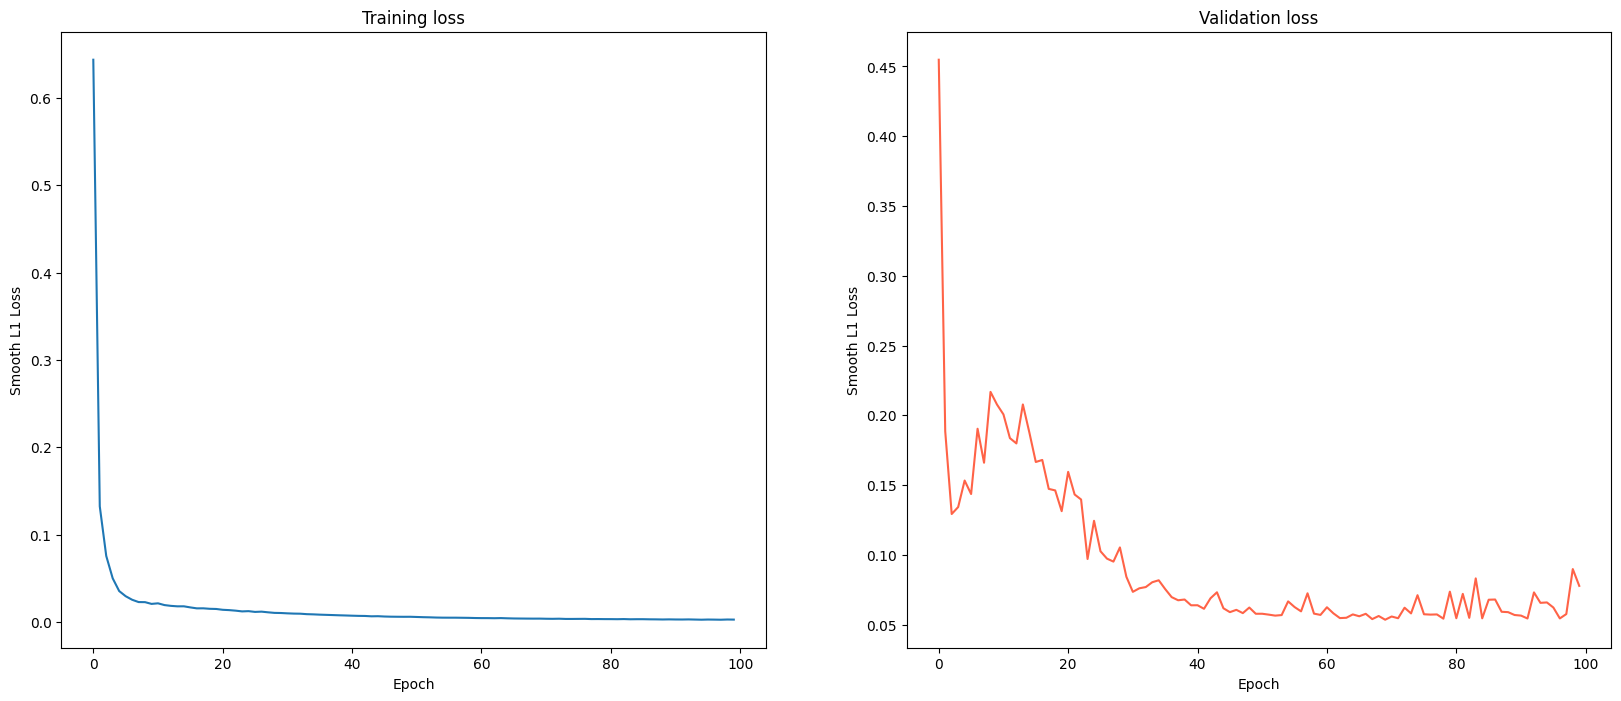

In [46]:
optimizer.param_groups[0]['lr']=0.0001

epoch_plot=[]
val_plot=[]
num_epochs=100
counter=0
teacher_forcing_rate=1.
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train(teacher_forcing_rate=teacher_forcing_rate)
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()

    val_plot.append(val_loss)

    teacher_forcing_rate=max(teacher_forcing_rate-0.05, 0.5)
    if teacher_forcing_rate<0.5:
      teacher_forcing_rate=0.9

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("Smooth L1 Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot, color='tomato')
ax[1].set_ylabel("Smooth L1 Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
path="/content/drive/MyDrive/stockprices/checkpoint_AAPL.pth"
torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':trainer.optimizer.state_dict(),
                  'epoch': epoch}, path)

In [ ]:
# path="/content/drive/MyDrive/stockprices/checkpoint_GOOGL.pth"
# checkpoint = torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])
# trainer.model=model

# Testing

In [47]:
#window size: 65, context_len:5, pred_len: 5 
prediction=trainer.test(test_loader)
prediction=[i.cpu().detach().numpy() for i in prediction]

In [49]:
gc.collect()
torch.cuda.empty_cache()
print(len(prediction))
print(np.array(prediction).shape)


3315
(3315, 7, 1)


In [58]:
prediction=np.squeeze(prediction)
prediction_padded=np.pad(prediction,((context_len+1, pred_len),(0,0)),'edge')
print(prediction_padded.shape)

(3353, 7)


### **Inverse Transform**

In [72]:
prediction_window=np.zeros_like(prediction_padded)
for i in range(pred_len):
  dataset_copy=dataset_standard.copy()
  dataset_copy[:,3]=prediction_padded[:,i]
  dataset_inverse=Scaler.inverse_transform(dataset_copy)
  prediction_window[:,i]=dataset_inverse[:,3]

print(prediction_window.shape)

(3353, 7)


In [73]:
actual_data=Scaler.inverse_transform(dataset_standard)
print(actual_data.shape)

(3353, 8)


### **Plot Results**

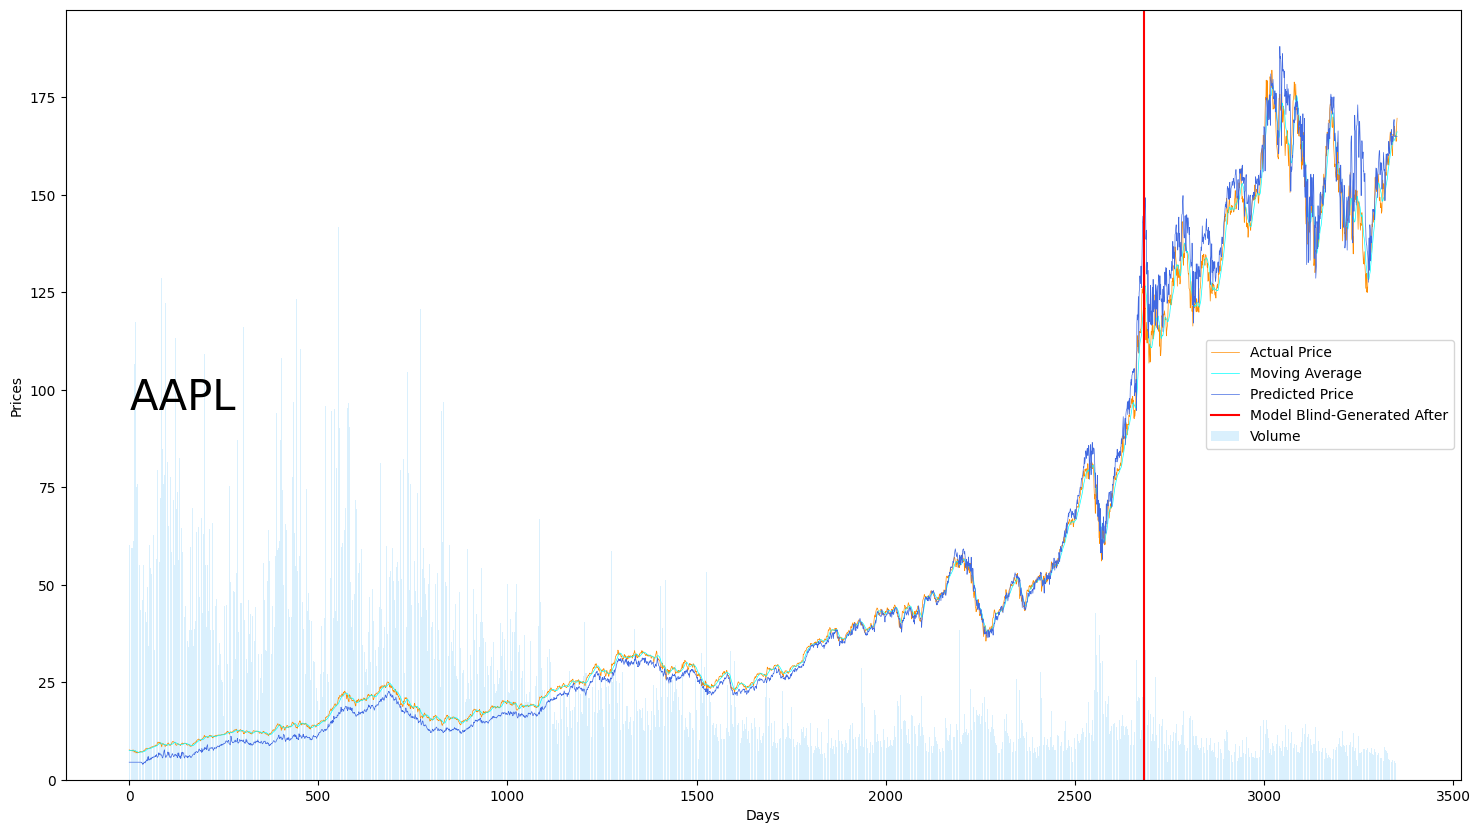

In [82]:
plt.figure(figsize=(18,10))
plt.plot(np.array(actual_data)[:,3], label='Actual Price', color='darkorange', linewidth=0.5)
plt.plot(np.array(actual_data)[:,7], label='Moving Average', color='cyan',linewidth=0.5)
plt.bar(x=np.arange(0,len(dataset)), height=np.array(actual_data)[:,4]/10000000 , label='Volume', color='lightskyblue', alpha=0.3)

plt.plot( prediction_window[:,0], label='Predicted Price',color='royalblue', linewidth=0.5)
plt.axvline(x = int(len(dataset)*0.8), color='r', label="Model Blind-Generated After")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Prices")
plt.annotate("AAPL",xy=(0.3,70),textcoords='offset points', fontsize=30)
plt.savefig("AAPL1.png", transparent = False)

### **Retrieve all predictions for DQN**

In [79]:
dff=pd.DataFrame(prediction_window)
dff.to_csv("AAPL_Pred.csv")
dff

,0,1,2,3,4,5,6
0,4.495150,4.467840,4.479853,4.422995,4.493061,4.411793,4.482191
1,4.495150,4.467840,4.479853,4.422995,4.493061,4.411793,4.482191
2,4.495150,4.467840,4.479853,4.422995,4.493061,4.411793,4.482191
3,4.495150,4.467840,4.479853,4.422995,4.493061,4.411793,4.482191
4,4.495150,4.467840,4.479853,4.422995,4.493061,4.411793,4.482191
...,...,...,...,...,...,...,...
3348,165.002884,166.625488,167.236221,166.629028,167.515930,167.248215,167.660156
3349,165.002884,166.625488,167.236221,166.629028,167.515930,167.248215,167.660156
3350,165.002884,166.625488,167.236221,166.629028,167.515930,167.248215,167.660156
3351,165.002884,166.625488,167.236221,166.629028,167.515930,167.248215,167.660156


# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle